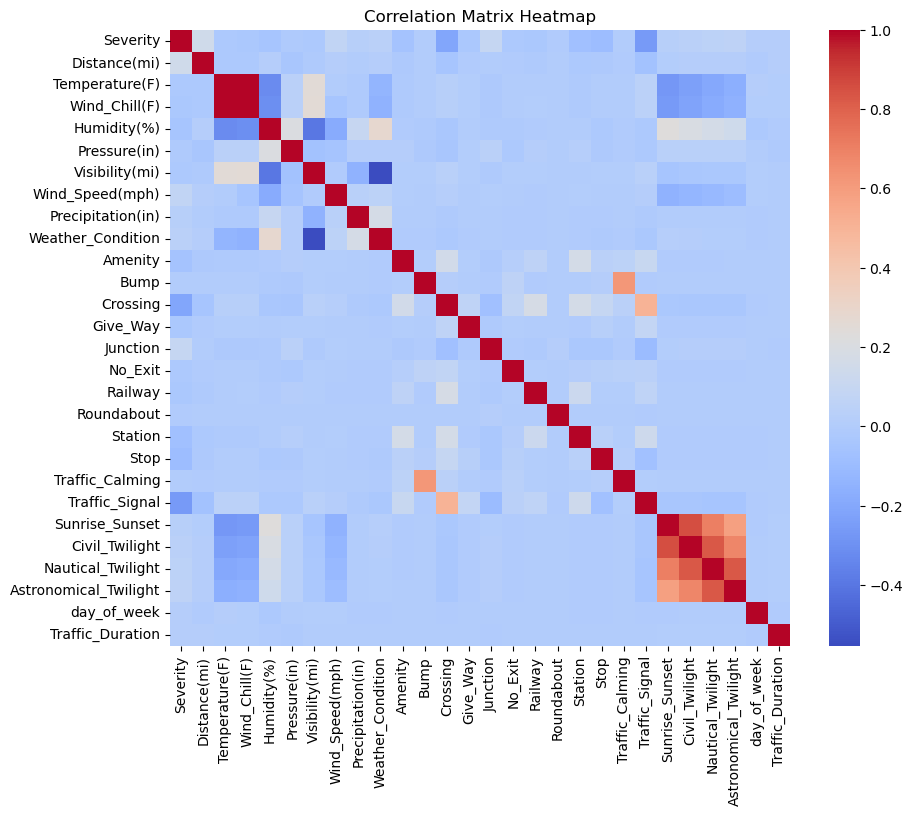

In [9]:
import argparse
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

def remove_missing_data(df):
    """
    Remove rows with missing data for any of the columns in the DataFrame.

    Parameters:
    - df: pandas DataFrame

    Returns:
    - DataFrame without rows containing missing data
    """

    # NEED TO DROP EVERY SAMPLE FROM SOURCE1 AS THESE HAVE INACCURATE START/END TIMES
    cleaned_df = df.dropna()
    return cleaned_df

# FEATURES:

    # determine the distance in time between when the weather was recorded and the start time of the accident
    # REMOVE:
        # Start_Lat
        # Start_Lng
        # End_Lat
        # End_Lng
        # Distance
        # Street
        # City
        # County
        # State
        # Country
        # Timezone
        # Airport_Code
        # Weather_Timestamp
        # Turning Loop
    # ONE HOT ENCODE:
        # Turn all true values into 1 and all false values into 0
        # Weather_Condition
        # Sunrise_Sunset (Day = 0, Night = 1, Other = 3)
        # Civil_Twilight
        # Nautical_Twilight
        # Astronomical_Twilight

# STEP 1
def remove_source1_data(df):
    cleaned_df = df[df['Source'] != 'Source1']
    df = df.drop(columns=['Source'])

    return cleaned_df

# STEP 2
def prepare_data(df):
    # take only releveant features
    selected_features = ['Severity', 'Start_Time', 'End_Time', 'Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']
    
    # clean this data by removing missing data
    cleaned_data = remove_missing_data(df[selected_features]) 

    #cleaned_data = cleaned_data.drop_duplicates()

    # turn categorical data data into numerical data:
    # for Weather_Condition, have six possible values to indicate no special condition (0), rain (1), snow (2), fog (3), rain (4), thunderstorm (5)
    cleaned_data = group_weather_conditions(cleaned_data)

    # convert values in specific columns
    cleaned_data['Sunrise_Sunset'] = cleaned_data['Sunrise_Sunset'].replace({'Day': 0, 'Night': 1})
    cleaned_data['Civil_Twilight'] = cleaned_data['Civil_Twilight'].replace({'Day': 0, 'Night': 1})
    cleaned_data['Nautical_Twilight'] = cleaned_data['Nautical_Twilight'].replace({'Day': 0, 'Night': 1})
    cleaned_data['Astronomical_Twilight'] = cleaned_data['Astronomical_Twilight'].replace({'Day': 0, 'Night': 1})

    # convert 'false' to 0 and 'true' to 1 in boolean columns
    bool_columns = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']
    cleaned_data[bool_columns] = cleaned_data[bool_columns].replace({False: 0, True: 1})

    cleaned_data = remove_missing_data(cleaned_data) 

    return cleaned_data

# STEP 3 - extract important features including the target variable (traffic duraction) and others (day of week)
def extract_features(df):

    # Extract day of the week as a categorical feature
    df['day_of_week'] = pd.to_datetime(df['Start_Time'], format='%Y-%m-%d %H:%M:%S').dt.strftime('%A')

    def get_day_of_week(day_of_week):
        if day_of_week == 'Sunday':
            return 0
        elif day_of_week == 'Monday':
            return 1 
        elif day_of_week == 'Tuesday':
            return 2
        elif day_of_week == 'Wednesday':
            return 3
        elif day_of_week == 'Thursday':
            return 4
        elif day_of_week == 'Friday':
            return 5
        elif day_of_week == 'Saturday':
            return 6

    df['day_of_week'] = df['day_of_week'].apply(get_day_of_week)

    # Extract traffic duration in minutes
    df['Start_Time'] = pd.to_datetime(df['Start_Time'], format='%Y-%m-%d %H:%M:%S')
    df['End_Time'] = pd.to_datetime(df['End_Time'], format='%Y-%m-%d %H:%M:%S')
    df['Traffic_Duration'] = round((df['End_Time'] - df['Start_Time']).dt.total_seconds() / 60)

    df = df.drop(columns=['Start_Time', 'End_Time'])

    return df

def group_weather_conditions(df):
    weather_mapping = {
        'Light Rain': 1,
        'Overcast': 0,
        'Mostly Cloudy': 0,
        'Rain': 1,
        'Light Snow': 2,
        'Haze': 3,
        'Scattered Clouds': 0,
        'Partly Cloudy': 0,
        'Clear': 0,
        'Snow': 2,
        'Light Freezing Drizzle': 1,
        'Light Drizzle': 1,
        'Fog': 3,
        'Shallow Fog': 3,
        'Heavy Rain': 1,
        'Light Freezing Rain': 1,
        'Cloudy': 0,
        'Drizzle': 1,
        'Light Rain Showers': 1,
        'Mist': 1,
        'Smoke': 3,
        'Patches of Fog': 3,
        'Light Freezing Fog': 3,
        'Light Haze': 3,
        'Light Thunderstorms and Rain': 5,
        'Thunderstorms and Rain': 5,
        'Fair': 0,
        'Volcanic Ash': 3,
        'Blowing Sand': 3,
        'Blowing Dust / Windy': 3,
        'Widespread Dust': 3,
        'Fair / Windy': 0,
        'Rain Showers': 1,
        'Mostly Cloudy / Windy': 0,
        'Light Rain / Windy': 1,
        'Hail': 4,
        'Heavy Drizzle': 1,
        'Showers in the Vicinity': 1,
        'Thunderstorm': 5,
        'Light Rain Shower': 1,
        'Light Rain with Thunder': 5,
        'Partly Cloudy / Windy': 0,
        'Thunder in the Vicinity': 5,
        'T-Storm': 5,
        'Heavy Thunderstorms and Rain': 5,
        'Thunder': 5,
        'Heavy T-Storm': 5,
        'Funnel Cloud': 5,
        'Heavy T-Storm / Windy': 5,
        'Blowing Snow': 2,
        'Light Thunderstorms and Snow': 5,
        'Heavy Snow': 2,
        'Low Drifting Snow': 2,
        'Light Ice Pellets': 2,
        'Ice Pellets': 2,
        'Squalls': 5,
        'N/A Precipitation': 0,
        'Cloudy / Windy': 0,
        'Light Fog': 3,
        'Sand': 3,
        'Snow Grains': 2,
        'Snow Showers': 2,
        'Heavy Thunderstorms and Snow': 5,
        'Rain / Windy': 1,
        'Heavy Rain / Windy': 1,
        'Heavy Ice Pellets': 2,
        'Light Snow / Windy': 2,
        'Heavy Freezing Rain': 1,
        'Small Hail': 4,
        'Heavy Rain Showers': 1,
        'Thunder / Windy': 5,
        'Drizzle and Fog': 3,
        'T-Storm / Windy': 5,
        'Blowing Dust': 3,
        'Smoke / Windy': 3,
        'Haze / Windy': 3,
        'Tornado': 5,
        'Light Drizzle / Windy': 1,
        'Widespread Dust / Windy': 3,
        'Wintry Mix': 1,
        'Wintry Mix / Windy': 1,
        'Light Snow with Thunder': 5,
        'Fog / Windy': 3,
        'Snow and Thunder': 5,
        'Light Snow Shower': 2,
        'Sleet': 2,
        'Light Snow and Sleet': 2,
        'Snow / Windy': 2,
        'Rain Shower': 1,
        'Snow and Sleet': 2,
        'Light Sleet': 2,
        'Heavy Snow / Windy': 2,
        'Freezing Drizzle': 1,
        'Light Freezing Rain / Windy': 1,
        'Thunder / Wintry Mix': 5,
        'Blowing Snow / Windy': 2,
        'Freezing Rain': 1,
        'Light Snow and Sleet / Windy': 2,
        'Snow and Sleet / Windy': 2,
        'Sleet / Windy': 2,
        'Heavy Freezing Rain / Windy': 1,
        'Squalls / Windy': 5,
        'Light Rain Shower / Windy': 1,
        'Snow and Thunder / Windy': 5,
        'Light Sleet / Windy': 2,
        'Sand / Dust Whirlwinds': 3,
        'Mist / Windy': 3,
        'Drizzle / Windy': 1,
        'Duststorm': 3,
        'Sand / Dust Whirls Nearby': 3,
        'Thunder and Hail': 5,
        'Heavy Sleet': 2,
        'Freezing Rain / Windy': 1,
        'Light Snow Shower / Windy': 2,
        'Partial Fog': 3,
        'Thunder / Wintry Mix / Windy': 5,
        'Patches of Fog / Windy': 3,
        'Rain and Sleet': 2,
        'Light Snow Grains': 2,
        'Partial Fog / Windy': 3,
        'Sand / Dust Whirlwinds / Windy': 3,
        'Heavy Snow with Thunder': 5,
        'Light Snow Showers': 2,
        'Heavy Blowing Snow': 2,
        'Light Hail': 4,
        'Heavy Smoke': 3,
        'Heavy Thunderstorms with Small Hail': 5,
        'Light Thunderstorm': 5,
        'Heavy Freezing Drizzle': 1,
        'Light Blowing Snow': 2,
        'Thunderstorms and Snow': 5,
    }
    df['Weather_Condition'] = df['Weather_Condition'].replace(weather_mapping)
    
    return df

def cal_corr(df):
    # calculate the correlation matrix and perform the heatmap
    corrMat = df.corr(method='pearson')
    return corrMat

# def select_features(df):
#     selected_features = ['hour', 'RH_out', 'RH_8', 'T2', 'lights']
#     return df[selected_features]


def main():
    """
    Main file to run from the command line.
    """
    # set up the program to take in arguments from the command line

    # # load the train and test data
    preparedxFeat = pd.read_csv('prepared_data.csv')

    # noSource1 = remove_source1_data(xFeat)
    
    # # Save the cleaned DataFrame to a new CSV file
    # noSource1.to_csv('noSource1.csv', index=False)

    #preparedxFeat = prepare_data(xFeat)

    #preparedxFeat = extract_features(preparedxFeat)

    #preparedxFeat.to_csv('prepared_data.csv', index=False)

    corrM = cal_corr(preparedxFeat)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corrM, annot=False, cmap="coolwarm")
    plt.title("Correlation Matrix Heatmap")
    plt.show()
    


if __name__ == "__main__":
    main()

